In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from bams.testsystems import *
from bams.sams_adapter import SAMSAdaptor

## Rao-Blackwellized vs binary update for Gaussian mixtures

In [2]:
# Parameters of the system and free energies
f_range = 10.0
nstates = 5

# Parameters of sams
niterations = 1000
repeats = 100
beta = 0.6

# Parameters of the sampler
nmoves = 10
save_freq = 10

### Rao-Blackwellized update

In [3]:
f_true = np.random.uniform(low=-f_range/2.0, high=f_range/2.0, size=nstates )
f_true -= f_true[0]
sigmas = gen_sigmas(sigma1=1, f=f_true)

generator = GaussianMixtureSampler(sigmas=sigmas)
adaptor = SAMSAdaptor(nstates=nstates, beta=beta)

rb_aggregate_msd = np.zeros((repeats,niterations))
for r in range(repeats):
    for i in range(niterations):
        generator.sample(nmoves, save_freq)
        state = generator.state
        noisy = generator.weights
        z = -adaptor.update(state=state, noisy_observation=noisy, histogram=generator.state_counter)
        generator.zetas = z
        rb_aggregate_msd[r,i] = np.mean((f_true - z)**2)

### Binary update

In [4]:
f_true = np.random.uniform(low=-f_range/2.0, high=f_range/2.0, size=nstates )
f_true -= f_true[0]
sigmas = gen_sigmas(sigma1=1, f=f_true)

generator = GaussianMixtureSampler(sigmas=sigmas)
adaptor = SAMSAdaptor(nstates=nstates, beta=beta)

binary_aggregate_msd = np.zeros((repeats,niterations))
for r in range(repeats):
    for i in range(niterations):
        noisy = generator.sample(nmoves, save_freq)
        state = generator.state
        z = -adaptor.update(state=state, noisy_observation=noisy, histogram=generator.state_counter)
        generator.zetas = z
        binary_aggregate_msd[r,i] = np.mean((f_true - z)**2)

#### Plotting

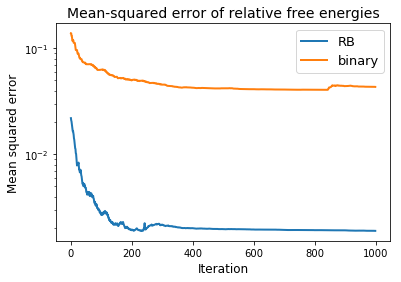

In [5]:
plt.semilogy(rb_aggregate_msd.mean(axis=0), lw=2, label='RB')
plt.semilogy(binary_aggregate_msd.mean(axis=0), lw=2, label='binary')

plt.title('Mean-squared error of relative free energies', fontsize=14)
plt.ylabel('Mean squared error', fontsize=12)
plt.xlabel('Iteration', fontsize=12)
plt.legend(fontsize=13)
plt.show()
